In [17]:
import sys
sys.path.append('..')

import os

from spp import process
from spp import market
import numpy as np
import pandas as pd
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [6]:
ticker = "CMCSA"
def_pipe = process.BaselineBinPipeline(ticker, period="1y", test_coef=1/12)
def_pipe

BaselineBinPipeline(_cut_stage, _lnprof_stage, _window_stage, _target_stage, _binarize_stage, _drop_stage, _target_stage, _drop_stage, _traintest_stage, _pop_stage, _pop_stage, _targetsseparate_stage)

In [7]:
X_train, y_train, X_test, y_test = def_pipe.get_data()

[*********************100%***********************]  1 of 1 completed


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:199: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe_list[i][attribute_name+"_LnProf"] = lnprofs


In [8]:
class MovingAverageBin:
    def fit(self, x_data, y_data):
        return self
    def predict(self, data):
        prediction = []
        for index, row in data.iterrows():
            row_sum = 0
            for item in row:
                row_sum += item
            if row_sum / len(row) > row[-1]:
                prediction.append(1)
            else:
                prediction.append(0)
        return pd.DataFrame(prediction)
    
    def score(self, x_data, y_data):
        if len(y_data) != len(x_data):
            raise Exception("Different data length")
        return sum(np.array(self.predict(x_data)).flatten() == np.array(y_data).flatten()) / len(y_data)

## Moving Average baseline

Model earned 97869.45$ out of 103350.23$ starting from 100000$ 
Train accuracy 0.49 
Test accuracy  0.40


C:\Users\valer\Desktop\SPP\SPP\model\..\spp\process.py:377: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Price_True"] = self.true_price_keeper[train_test_id].to_numpy()


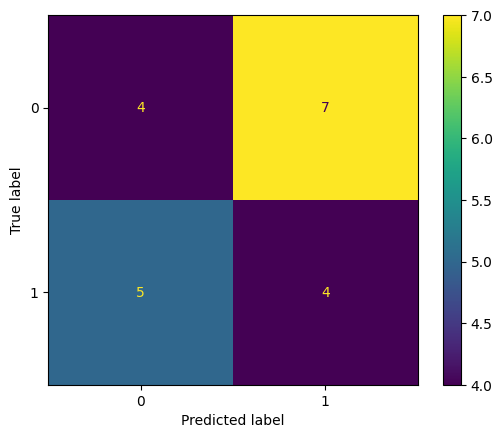

In [9]:
ma_model = MovingAverageBin().fit(X_train, y_train)
y_train_pred_bin = ma_model.predict(X_train)
y_test_pred_bin = ma_model.predict(X_test)

df = def_pipe.get_test_price(y_test_pred_bin)  # ! Prediction_ExpProf will not be corret as we 
                                               # ! proposed bin not price

start_capital = 100000
tt = market.BinTraderTest(start_capital, y_test_pred_bin, df["Price_True"])
bt = market.BinTraderTest(start_capital, y_test, df["Price_True"])
traded_capital = tt.trade()
maximal_caital = bt.trade()
print(f"Model earned {(traded_capital):.2f}$ out of {maximal_caital:.2f}$ starting from {start_capital}$ ")

print(f"Train accuracy {ma_model.score(X_train, y_train):.2f} \nTest accuracy  {ma_model.score(X_test, y_test):.2f}")

_ = ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_bin)

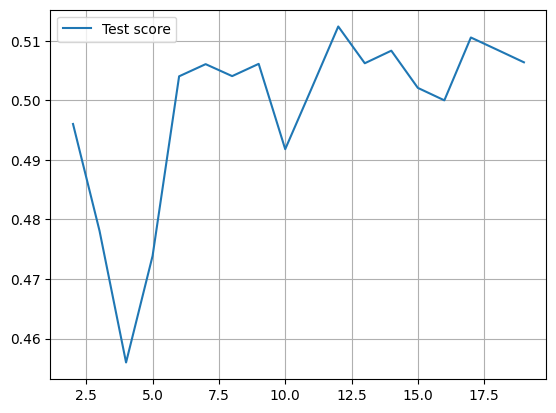

In [25]:
window_sizes = [i for i in range(2, 20)]
X = []
Y = []
orig_stdout = sys.stdout
orig_stderr = sys.stderr
f = open(os.devnull, 'w')
sys.stdout = f
sys.stderr = f
for window_size in window_sizes:
    def_pipe = process.BaselineBinPipeline(ticker, start="2021-05-25", end="2022-05-25", test_coef=1, window_size=window_size)
    X_train, y_train, X_test, y_test = def_pipe.get_data()
    ma_model = MovingAverageBin().fit(X_train, y_train)
    y_test_pred_bin = ma_model.predict(X_test)
    X.append(window_size)
    Y.append(ma_model.score(X_test, y_test))
sys.stdout = orig_stdout
sys.stderr = orig_stderr
plt.plot(X, Y, label="Test score")
plt.legend()
plt.grid()
plt.show()

In [20]:
tickers = ["EBAY", "ALGN", "CMCSA"]
byt = market.BinYearTest(tickers, process.BaselineBinPipeline, end_date=None, window_size=12, train_period="1mo")

In [21]:
orig_stdout = sys.stdout
orig_stderr = sys.stderr
f = open(os.devnull, 'w')
sys.stdout = f
sys.stderr = f
year_test_df = byt.trade(ma_model)
sys.stdout = orig_stdout
sys.stderr = orig_stderr

In [29]:
pd.options.display.float_format = '{:,.2f}'.format
year_test_df

,Month,TrainAcc,TestAcc,Income,Potential
0,May_2022,0.61,0.47,1.04,0.22
1,Jun_2022,0.52,0.50,0.96,-0.36
2,Jul_2022,0.57,0.51,1.03,0.24
3,Aug_2022,0.47,0.52,1.01,0.07
4,Sep_2022,0.53,0.56,0.98,-0.22
5,Oct_2022,0.52,0.51,1.02,0.20
6,Nov_2022,0.50,0.47,1.07,0.42
7,Dec_2022,0.47,0.61,1.01,0.07
8,Jan_2023,0.73,0.49,1.04,0.26
9,Feb_2023,0.43,0.41,0.94,-0.34


In [23]:
year_test_df.mean()

C:\Users\valer\AppData\Local\Temp\ipykernel_18724\561746647.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  year_test_df.mean()


TrainAcc     0.524439
TestAcc      0.508455
Income       1.013266
Potential    0.082406
dtype: float64

In [24]:
from functools import reduce
items = list(year_test_df["Income"])
reduced_income = reduce(lambda a,b: a*b, items)
print(f"Year capital multiplier {reduced_income:.2f}")

Year capital multiplier 1.16
